<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:15:35] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


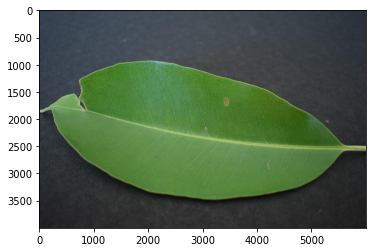

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

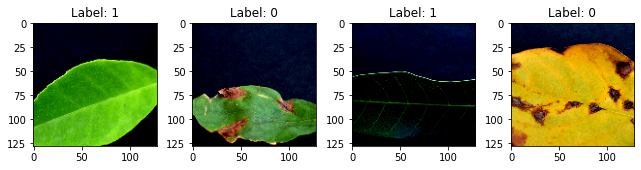

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:15:41] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:15:43] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2697176430130026 samples/sec                   batch loss = 1.287431240081787 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.292789315195731 samples/sec                   batch loss = 1.1734751462936401 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2658915177305907 samples/sec                   batch loss = 0.39402782917022705 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2970677538898001 samples/sec                   batch loss = 0.5731101632118225 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2971646296204662 samples/sec                   batch loss = 0.46614840626716614 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.299062939900239 samples/sec                   batch loss = 0.4370775520801544 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2975419410318594 samples/sec                   batch loss = 0.8793236613273621 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.3058144224750674 samples/sec                   batch loss = 0.8280848264694214 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2986533795012327 samples/sec                   batch loss = 0.41593751311302185 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2909056074457141 samples/sec                   batch loss = 0.7326368689537048 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.29899937222678 samples/sec                   batch loss = 0.3143012821674347 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2870230895582246 samples/sec                   batch loss = 0.9383605718612671 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2991069983619863 samples/sec                   batch loss = 0.5654323697090149 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.3006814825794886 samples/sec                   batch loss = 0.6765925884246826 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2899764728605192 samples/sec                   batch loss = 0.3730030357837677 | accuracy = 0.6133333333333333


Epoch[1] Batch[80] Speed: 1.291592523779485 samples/sec                   batch loss = 0.4756380319595337 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.2931564102526552 samples/sec                   batch loss = 0.8785051107406616 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.2944485791030838 samples/sec                   batch loss = 0.5805317759513855 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.2979632521061362 samples/sec                   batch loss = 0.32137584686279297 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.3021880233774552 samples/sec                   batch loss = 0.8709031939506531 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.3046934375394905 samples/sec                   batch loss = 0.4864599406719208 | accuracy = 0.6333333333333333


Epoch[1] Batch[110] Speed: 1.2992584092347221 samples/sec                   batch loss = 0.5434441566467285 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.297113482245229 samples/sec                   batch loss = 0.392582505941391 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.3033953255812725 samples/sec                   batch loss = 0.35201889276504517 | accuracy = 0.63125


Epoch[1] Batch[125] Speed: 1.3023694714925884 samples/sec                   batch loss = 0.8732236623764038 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2982435749687127 samples/sec                   batch loss = 0.7601209282875061 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2970320559235728 samples/sec                   batch loss = 0.5079345107078552 | accuracy = 0.6388888888888888


Epoch[1] Batch[140] Speed: 1.2957441334871904 samples/sec                   batch loss = 0.5237448811531067 | accuracy = 0.6428571428571429


Epoch[1] Batch[145] Speed: 1.2972085594095624 samples/sec                   batch loss = 0.5781369209289551 | accuracy = 0.6448275862068965


Epoch[1] Batch[150] Speed: 1.301536541193912 samples/sec                   batch loss = 1.2861920595169067 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.3043321352684707 samples/sec                   batch loss = 0.7894814014434814 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.298883216364123 samples/sec                   batch loss = 0.6626892685890198 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.2958768443916566 samples/sec                   batch loss = 0.4736606180667877 | accuracy = 0.6409090909090909


Epoch[1] Batch[170] Speed: 1.2953566651523354 samples/sec                   batch loss = 0.20275144279003143 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2946313731820838 samples/sec                   batch loss = 0.6774914860725403 | accuracy = 0.6485714285714286


Epoch[1] Batch[180] Speed: 1.30139913538007 samples/sec                   batch loss = 0.9611342549324036 | accuracy = 0.65


Epoch[1] Batch[185] Speed: 1.2963783085637368 samples/sec                   batch loss = 0.6591306924819946 | accuracy = 0.6513513513513514


Epoch[1] Batch[190] Speed: 1.3030942517172552 samples/sec                   batch loss = 0.45143836736679077 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.2983146039591702 samples/sec                   batch loss = 0.7219762802124023 | accuracy = 0.6525641025641026


Epoch[1] Batch[200] Speed: 1.3024861506366356 samples/sec                   batch loss = 0.3289387822151184 | accuracy = 0.65875


Epoch[1] Batch[205] Speed: 1.3003145376734877 samples/sec                   batch loss = 0.35755714774131775 | accuracy = 0.6597560975609756


Epoch[1] Batch[210] Speed: 1.3015114001218255 samples/sec                   batch loss = 0.23002581298351288 | accuracy = 0.6619047619047619


Epoch[1] Batch[215] Speed: 1.3073862671582985 samples/sec                   batch loss = 0.698508620262146 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.3028923651738877 samples/sec                   batch loss = 0.3733762502670288 | accuracy = 0.6625


Epoch[1] Batch[225] Speed: 1.2986503638101603 samples/sec                   batch loss = 0.6224470138549805 | accuracy = 0.6611111111111111


Epoch[1] Batch[230] Speed: 1.2963763051394241 samples/sec                   batch loss = 0.45740875601768494 | accuracy = 0.6608695652173913


Epoch[1] Batch[235] Speed: 1.2983503725599268 samples/sec                   batch loss = 0.3211211860179901 | accuracy = 0.6627659574468086


Epoch[1] Batch[240] Speed: 1.2918790542030112 samples/sec                   batch loss = 0.6729534864425659 | accuracy = 0.6645833333333333


Epoch[1] Batch[245] Speed: 1.2901275485016197 samples/sec                   batch loss = 0.4665881395339966 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.292043212540105 samples/sec                   batch loss = 0.4322132468223572 | accuracy = 0.662


Epoch[1] Batch[255] Speed: 1.2985790970544764 samples/sec                   batch loss = 0.3504917621612549 | accuracy = 0.6607843137254902


Epoch[1] Batch[260] Speed: 1.2973580232097046 samples/sec                   batch loss = 0.5899509787559509 | accuracy = 0.6625


Epoch[1] Batch[265] Speed: 1.2966380047689883 samples/sec                   batch loss = 0.14907629787921906 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2951360728385586 samples/sec                   batch loss = 0.6102880239486694 | accuracy = 0.6685185185185185


Epoch[1] Batch[275] Speed: 1.295647469805362 samples/sec                   batch loss = 0.6485391855239868 | accuracy = 0.6672727272727272


Epoch[1] Batch[280] Speed: 1.2959935643782714 samples/sec                   batch loss = 0.41681745648384094 | accuracy = 0.6678571428571428


Epoch[1] Batch[285] Speed: 1.2980646806540483 samples/sec                   batch loss = 0.7098902463912964 | accuracy = 0.6666666666666666


Epoch[1] Batch[290] Speed: 1.300332980784896 samples/sec                   batch loss = 0.6053857207298279 | accuracy = 0.6672413793103448


Epoch[1] Batch[295] Speed: 1.2983975981694973 samples/sec                   batch loss = 0.6133392453193665 | accuracy = 0.6669491525423729


Epoch[1] Batch[300] Speed: 1.2931425557045375 samples/sec                   batch loss = 0.3388669490814209 | accuracy = 0.6691666666666667


Epoch[1] Batch[305] Speed: 1.2972558022975753 samples/sec                   batch loss = 0.7061895132064819 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.296134937830437 samples/sec                   batch loss = 0.46725672483444214 | accuracy = 0.6717741935483871


Epoch[1] Batch[315] Speed: 1.298803075902632 samples/sec                   batch loss = 0.7395976781845093 | accuracy = 0.6706349206349206


Epoch[1] Batch[320] Speed: 1.3042233375000778 samples/sec                   batch loss = 0.5314791202545166 | accuracy = 0.67109375


Epoch[1] Batch[325] Speed: 1.3034945666800715 samples/sec                   batch loss = 0.83553147315979 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2983373107637952 samples/sec                   batch loss = 0.5509405732154846 | accuracy = 0.675


Epoch[1] Batch[335] Speed: 1.297517255086814 samples/sec                   batch loss = 0.574224591255188 | accuracy = 0.6746268656716418


Epoch[1] Batch[340] Speed: 1.2979978967087973 samples/sec                   batch loss = 0.16566058993339539 | accuracy = 0.6786764705882353


Epoch[1] Batch[345] Speed: 1.3010139278893798 samples/sec                   batch loss = 0.6795306205749512 | accuracy = 0.6789855072463769


Epoch[1] Batch[350] Speed: 1.2998431561895973 samples/sec                   batch loss = 1.0925365686416626 | accuracy = 0.6757142857142857


Epoch[1] Batch[355] Speed: 1.296699236891851 samples/sec                   batch loss = 0.42883506417274475 | accuracy = 0.6746478873239437


Epoch[1] Batch[360] Speed: 1.2980905926666293 samples/sec                   batch loss = 0.6696456074714661 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.295375067906521 samples/sec                   batch loss = 0.390708327293396 | accuracy = 0.6753424657534246


Epoch[1] Batch[370] Speed: 1.2956019448065388 samples/sec                   batch loss = 0.40180784463882446 | accuracy = 0.6763513513513514


Epoch[1] Batch[375] Speed: 1.292886648814986 samples/sec                   batch loss = 0.4802073538303375 | accuracy = 0.6766666666666666


Epoch[1] Batch[380] Speed: 1.2959599276459368 samples/sec                   batch loss = 0.3509213924407959 | accuracy = 0.6769736842105263


Epoch[1] Batch[385] Speed: 1.3032882026630954 samples/sec                   batch loss = 0.4845173954963684 | accuracy = 0.6772727272727272


Epoch[1] Batch[390] Speed: 1.297324014660802 samples/sec                   batch loss = 0.4352951645851135 | accuracy = 0.6762820512820513


Epoch[1] Batch[395] Speed: 1.2972251090742963 samples/sec                   batch loss = 0.4322250485420227 | accuracy = 0.6772151898734177


Epoch[1] Batch[400] Speed: 1.296889383956486 samples/sec                   batch loss = 0.44057974219322205 | accuracy = 0.675625


Epoch[1] Batch[405] Speed: 1.2969828240310652 samples/sec                   batch loss = 0.4984251856803894 | accuracy = 0.6765432098765433


Epoch[1] Batch[410] Speed: 1.3020593724289664 samples/sec                   batch loss = 0.47854742407798767 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.2967377228876942 samples/sec                   batch loss = 0.9346169233322144 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.3021804430802655 samples/sec                   batch loss = 0.5428178310394287 | accuracy = 0.675


Epoch[1] Batch[425] Speed: 1.2994270651442414 samples/sec                   batch loss = 0.5797953009605408 | accuracy = 0.6747058823529412


Epoch[1] Batch[430] Speed: 1.300007733152614 samples/sec                   batch loss = 0.30834123492240906 | accuracy = 0.6755813953488372


Epoch[1] Batch[435] Speed: 1.301841845439678 samples/sec                   batch loss = 0.30123287439346313 | accuracy = 0.6781609195402298


Epoch[1] Batch[440] Speed: 1.298117610556577 samples/sec                   batch loss = 0.5956745743751526 | accuracy = 0.6801136363636363


Epoch[1] Batch[445] Speed: 1.2903368114885798 samples/sec                   batch loss = 0.8700509071350098 | accuracy = 0.6797752808988764


Epoch[1] Batch[450] Speed: 1.2940343370911034 samples/sec                   batch loss = 0.35067933797836304 | accuracy = 0.6811111111111111


Epoch[1] Batch[455] Speed: 1.2953334624249269 samples/sec                   batch loss = 0.15921150147914886 | accuracy = 0.6807692307692308


Epoch[1] Batch[460] Speed: 1.2989879065682246 samples/sec                   batch loss = 0.6401990056037903 | accuracy = 0.6804347826086956


Epoch[1] Batch[465] Speed: 1.2958681362818325 samples/sec                   batch loss = 0.5538493990898132 | accuracy = 0.6817204301075269


Epoch[1] Batch[470] Speed: 1.294902962639941 samples/sec                   batch loss = 0.45737624168395996 | accuracy = 0.6813829787234043


Epoch[1] Batch[475] Speed: 1.2929079705205058 samples/sec                   batch loss = 0.4830794334411621 | accuracy = 0.6815789473684211


Epoch[1] Batch[480] Speed: 1.2975403354133774 samples/sec                   batch loss = 0.42940187454223633 | accuracy = 0.6822916666666666


Epoch[1] Batch[485] Speed: 1.293523414654305 samples/sec                   batch loss = 0.9926249980926514 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.2925713888611319 samples/sec                   batch loss = 0.3861181139945984 | accuracy = 0.6836734693877551


Epoch[1] Batch[495] Speed: 1.2996381479670533 samples/sec                   batch loss = 0.270855575799942 | accuracy = 0.6848484848484848


Epoch[1] Batch[500] Speed: 1.3001917984892177 samples/sec                   batch loss = 0.29205065965652466 | accuracy = 0.6865


Epoch[1] Batch[505] Speed: 1.2973951437200217 samples/sec                   batch loss = 0.22580011188983917 | accuracy = 0.6871287128712872


Epoch[1] Batch[510] Speed: 1.3007745622415368 samples/sec                   batch loss = 0.32974815368652344 | accuracy = 0.6882352941176471


Epoch[1] Batch[515] Speed: 1.296020795392878 samples/sec                   batch loss = 0.7444341778755188 | accuracy = 0.6883495145631068


Epoch[1] Batch[520] Speed: 1.2990990515235548 samples/sec                   batch loss = 0.8333142399787903 | accuracy = 0.6899038461538461


Epoch[1] Batch[525] Speed: 1.2930220635571081 samples/sec                   batch loss = 0.2873925268650055 | accuracy = 0.6923809523809524


Epoch[1] Batch[530] Speed: 1.2879297806724586 samples/sec                   batch loss = 0.41505277156829834 | accuracy = 0.6924528301886792


Epoch[1] Batch[535] Speed: 1.2922365749154823 samples/sec                   batch loss = 0.5522364974021912 | accuracy = 0.6929906542056075


Epoch[1] Batch[540] Speed: 1.2969663808099994 samples/sec                   batch loss = 0.5521621704101562 | accuracy = 0.6935185185185185


Epoch[1] Batch[545] Speed: 1.2984627148565533 samples/sec                   batch loss = 0.4219149947166443 | accuracy = 0.6935779816513762


Epoch[1] Batch[550] Speed: 1.2938635856395253 samples/sec                   batch loss = 0.6432759165763855 | accuracy = 0.6940909090909091


Epoch[1] Batch[555] Speed: 1.2956020448579733 samples/sec                   batch loss = 0.2633401155471802 | accuracy = 0.6941441441441442


Epoch[1] Batch[560] Speed: 1.290976928460931 samples/sec                   batch loss = 1.5984957218170166 | accuracy = 0.6928571428571428


Epoch[1] Batch[565] Speed: 1.2932370516085667 samples/sec                   batch loss = 0.1723690629005432 | accuracy = 0.6942477876106194


Epoch[1] Batch[570] Speed: 1.3004527225596536 samples/sec                   batch loss = 0.5170155763626099 | accuracy = 0.6947368421052632


Epoch[1] Batch[575] Speed: 1.2969266781657238 samples/sec                   batch loss = 0.4773561954498291 | accuracy = 0.6956521739130435


Epoch[1] Batch[580] Speed: 1.2989212287232481 samples/sec                   batch loss = 0.7408838272094727 | accuracy = 0.694396551724138


Epoch[1] Batch[585] Speed: 1.301774369256267 samples/sec                   batch loss = 0.7579283714294434 | accuracy = 0.6948717948717948


Epoch[1] Batch[590] Speed: 1.2961993270388472 samples/sec                   batch loss = 0.6518628001213074 | accuracy = 0.6949152542372882


Epoch[1] Batch[595] Speed: 1.2970694586171208 samples/sec                   batch loss = 0.4433723986148834 | accuracy = 0.6949579831932773


Epoch[1] Batch[600] Speed: 1.2976966007856467 samples/sec                   batch loss = 0.22404000163078308 | accuracy = 0.6954166666666667


Epoch[1] Batch[605] Speed: 1.304952010165692 samples/sec                   batch loss = 0.31138506531715393 | accuracy = 0.697107438016529


Epoch[1] Batch[610] Speed: 1.3057443997579536 samples/sec                   batch loss = 0.3886142671108246 | accuracy = 0.6967213114754098


Epoch[1] Batch[615] Speed: 1.2980753265495193 samples/sec                   batch loss = 0.28672006726264954 | accuracy = 0.6971544715447154


Epoch[1] Batch[620] Speed: 1.2982651741929534 samples/sec                   batch loss = 0.5275523662567139 | accuracy = 0.6975806451612904


Epoch[1] Batch[625] Speed: 1.2978460766789184 samples/sec                   batch loss = 0.8323890566825867 | accuracy = 0.6984


Epoch[1] Batch[630] Speed: 1.3076225690395875 samples/sec                   batch loss = 0.7839164137840271 | accuracy = 0.698015873015873


Epoch[1] Batch[635] Speed: 1.2991953254660378 samples/sec                   batch loss = 0.3510979115962982 | accuracy = 0.6992125984251969


Epoch[1] Batch[640] Speed: 1.3033859085885864 samples/sec                   batch loss = 0.6616818904876709 | accuracy = 0.699609375


Epoch[1] Batch[645] Speed: 1.2999126481104206 samples/sec                   batch loss = 0.4523836076259613 | accuracy = 0.6992248062015504


Epoch[1] Batch[650] Speed: 1.3049305938621685 samples/sec                   batch loss = 0.6203997135162354 | accuracy = 0.7


Epoch[1] Batch[655] Speed: 1.2982810475693896 samples/sec                   batch loss = 0.44926244020462036 | accuracy = 0.7


Epoch[1] Batch[660] Speed: 1.2964597530042983 samples/sec                   batch loss = 0.4644536077976227 | accuracy = 0.6996212121212121


Epoch[1] Batch[665] Speed: 1.3022732319891068 samples/sec                   batch loss = 0.6206678152084351 | accuracy = 0.7


Epoch[1] Batch[670] Speed: 1.3024850383450632 samples/sec                   batch loss = 0.09850037097930908 | accuracy = 0.7003731343283582


Epoch[1] Batch[675] Speed: 1.2986271434580208 samples/sec                   batch loss = 0.4131498336791992 | accuracy = 0.7011111111111111


Epoch[1] Batch[680] Speed: 1.2995255015331602 samples/sec                   batch loss = 0.16925089061260223 | accuracy = 0.7018382352941176


Epoch[1] Batch[685] Speed: 1.3081873288908403 samples/sec                   batch loss = 1.1878066062927246 | accuracy = 0.7021897810218978


Epoch[1] Batch[690] Speed: 1.3046586375112874 samples/sec                   batch loss = 0.5553986430168152 | accuracy = 0.702536231884058


Epoch[1] Batch[695] Speed: 1.2969596632725728 samples/sec                   batch loss = 0.15285252034664154 | accuracy = 0.7043165467625899


Epoch[1] Batch[700] Speed: 1.3041890694551612 samples/sec                   batch loss = 0.438003808259964 | accuracy = 0.7053571428571429


Epoch[1] Batch[705] Speed: 1.2995993889474977 samples/sec                   batch loss = 0.22854183614253998 | accuracy = 0.7067375886524823


Epoch[1] Batch[710] Speed: 1.3030673298966413 samples/sec                   batch loss = 0.35658934712409973 | accuracy = 0.706338028169014


Epoch[1] Batch[715] Speed: 1.3077265322348062 samples/sec                   batch loss = 0.4116917550563812 | accuracy = 0.7066433566433566


Epoch[1] Batch[720] Speed: 1.2987475766365 samples/sec                   batch loss = 0.8457489013671875 | accuracy = 0.7069444444444445


Epoch[1] Batch[725] Speed: 1.3000980969775298 samples/sec                   batch loss = 0.2249043881893158 | accuracy = 0.7075862068965517


Epoch[1] Batch[730] Speed: 1.3014933274210805 samples/sec                   batch loss = 0.3412420451641083 | accuracy = 0.7078767123287671


Epoch[1] Batch[735] Speed: 1.2967307070411023 samples/sec                   batch loss = 0.39083826541900635 | accuracy = 0.7085034013605442


Epoch[1] Batch[740] Speed: 1.2983450473343874 samples/sec                   batch loss = 1.139406442642212 | accuracy = 0.7084459459459459


Epoch[1] Batch[745] Speed: 1.3035801489451486 samples/sec                   batch loss = 0.6515685319900513 | accuracy = 0.7093959731543624


Epoch[1] Batch[750] Speed: 1.303795521612909 samples/sec                   batch loss = 0.29938197135925293 | accuracy = 0.7103333333333334


Epoch[1] Batch[755] Speed: 1.3024501538007929 samples/sec                   batch loss = 0.716791033744812 | accuracy = 0.7096026490066225


Epoch[1] Batch[760] Speed: 1.2994317953862362 samples/sec                   batch loss = 0.2597716450691223 | accuracy = 0.7078947368421052


Epoch[1] Batch[765] Speed: 1.2967211856564402 samples/sec                   batch loss = 0.4354521930217743 | accuracy = 0.7084967320261438


Epoch[1] Batch[770] Speed: 1.3021953005457865 samples/sec                   batch loss = 0.31802546977996826 | accuracy = 0.7090909090909091


Epoch[1] Batch[775] Speed: 1.302135064213362 samples/sec                   batch loss = 0.3070094883441925 | accuracy = 0.7093548387096774


Epoch[1] Batch[780] Speed: 1.3008268056347707 samples/sec                   batch loss = 0.48370668292045593 | accuracy = 0.7092948717948718


Epoch[1] Batch[785] Speed: 1.3024760389649357 samples/sec                   batch loss = 0.5657970905303955 | accuracy = 0.7089171974522293


[Epoch 1] training: accuracy=0.7084390862944162
[Epoch 1] time cost: 634.2764339447021
[Epoch 1] validation: validation accuracy=0.7755555555555556


Epoch[2] Batch[5] Speed: 1.2929483242713031 samples/sec                   batch loss = 0.5901515483856201 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2964286967215002 samples/sec                   batch loss = 0.36621278524398804 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.3016976084514211 samples/sec                   batch loss = 0.5975003242492676 | accuracy = 0.8666666666666667


Epoch[2] Batch[20] Speed: 1.294933346176758 samples/sec                   batch loss = 0.2833760976791382 | accuracy = 0.8625


Epoch[2] Batch[25] Speed: 1.288543462340907 samples/sec                   batch loss = 0.32659900188446045 | accuracy = 0.82


Epoch[2] Batch[30] Speed: 1.2910916744859422 samples/sec                   batch loss = 0.4868353605270386 | accuracy = 0.825


Epoch[2] Batch[35] Speed: 1.2874780044923402 samples/sec                   batch loss = 0.9191515445709229 | accuracy = 0.8214285714285714


Epoch[2] Batch[40] Speed: 1.2934677673400856 samples/sec                   batch loss = 0.5146325826644897 | accuracy = 0.8125


Epoch[2] Batch[45] Speed: 1.2947270859716424 samples/sec                   batch loss = 0.2896484434604645 | accuracy = 0.8111111111111111


Epoch[2] Batch[50] Speed: 1.2929295918465644 samples/sec                   batch loss = 0.1382138431072235 | accuracy = 0.81


Epoch[2] Batch[55] Speed: 1.2917643671036656 samples/sec                   batch loss = 1.106533169746399 | accuracy = 0.8090909090909091


Epoch[2] Batch[60] Speed: 1.294000003547907 samples/sec                   batch loss = 0.6481302380561829 | accuracy = 0.8041666666666667


Epoch[2] Batch[65] Speed: 1.293739467344314 samples/sec                   batch loss = 0.6172451972961426 | accuracy = 0.8076923076923077


Epoch[2] Batch[70] Speed: 1.2912289991353179 samples/sec                   batch loss = 0.6884416341781616 | accuracy = 0.8035714285714286


Epoch[2] Batch[75] Speed: 1.2928808701561132 samples/sec                   batch loss = 0.5084933042526245 | accuracy = 0.8066666666666666


Epoch[2] Batch[80] Speed: 1.2899238080563957 samples/sec                   batch loss = 0.6856552362442017 | accuracy = 0.80625


Epoch[2] Batch[85] Speed: 1.2956195540969995 samples/sec                   batch loss = 0.28203973174095154 | accuracy = 0.8


Epoch[2] Batch[90] Speed: 1.2908847490282134 samples/sec                   batch loss = 0.16965898871421814 | accuracy = 0.8055555555555556


Epoch[2] Batch[95] Speed: 1.2907266442801013 samples/sec                   batch loss = 0.3278771936893463 | accuracy = 0.8052631578947368


Epoch[2] Batch[100] Speed: 1.2914479641770786 samples/sec                   batch loss = 0.3077906370162964 | accuracy = 0.805


Epoch[2] Batch[105] Speed: 1.2916343864877242 samples/sec                   batch loss = 0.6423225998878479 | accuracy = 0.8


Epoch[2] Batch[110] Speed: 1.2895530941689077 samples/sec                   batch loss = 0.3031378984451294 | accuracy = 0.7954545454545454


Epoch[2] Batch[115] Speed: 1.2945748313571201 samples/sec                   batch loss = 0.1451306790113449 | accuracy = 0.8


Epoch[2] Batch[120] Speed: 1.2952680592105212 samples/sec                   batch loss = 0.6587375402450562 | accuracy = 0.8020833333333334


Epoch[2] Batch[125] Speed: 1.2932870961719287 samples/sec                   batch loss = 0.3791758120059967 | accuracy = 0.802


Epoch[2] Batch[130] Speed: 1.2920853034871145 samples/sec                   batch loss = 1.205544352531433 | accuracy = 0.801923076923077


Epoch[2] Batch[135] Speed: 1.2995883153665257 samples/sec                   batch loss = 0.5369783043861389 | accuracy = 0.8074074074074075


Epoch[2] Batch[140] Speed: 1.2932590827020711 samples/sec                   batch loss = 0.37096109986305237 | accuracy = 0.8053571428571429


Epoch[2] Batch[145] Speed: 1.2917271702846675 samples/sec                   batch loss = 0.21426358819007874 | accuracy = 0.8051724137931034


Epoch[2] Batch[150] Speed: 1.2861263503022093 samples/sec                   batch loss = 0.17963895201683044 | accuracy = 0.805


Epoch[2] Batch[155] Speed: 1.2977731915859712 samples/sec                   batch loss = 0.1716790795326233 | accuracy = 0.8032258064516129


Epoch[2] Batch[160] Speed: 1.2883665385944782 samples/sec                   batch loss = 0.19254176318645477 | accuracy = 0.8


Epoch[2] Batch[165] Speed: 1.295899065616047 samples/sec                   batch loss = 0.42074650526046753 | accuracy = 0.7984848484848485


Epoch[2] Batch[170] Speed: 1.2958689370226772 samples/sec                   batch loss = 0.42279013991355896 | accuracy = 0.7941176470588235


Epoch[2] Batch[175] Speed: 1.294938143707648 samples/sec                   batch loss = 0.3414936661720276 | accuracy = 0.7971428571428572


Epoch[2] Batch[180] Speed: 1.295956924451172 samples/sec                   batch loss = 0.12035991251468658 | accuracy = 0.7986111111111112


Epoch[2] Batch[185] Speed: 1.2915525528946972 samples/sec                   batch loss = 0.3000256419181824 | accuracy = 0.7959459459459459


Epoch[2] Batch[190] Speed: 1.2928543686926288 samples/sec                   batch loss = 0.5139747858047485 | accuracy = 0.7921052631578948


Epoch[2] Batch[195] Speed: 1.2983355022281216 samples/sec                   batch loss = 0.5975672602653503 | accuracy = 0.7897435897435897


Epoch[2] Batch[200] Speed: 1.2941342540746925 samples/sec                   batch loss = 0.5912290811538696 | accuracy = 0.78625


Epoch[2] Batch[205] Speed: 1.2902947351469007 samples/sec                   batch loss = 0.4112760126590729 | accuracy = 0.7865853658536586


Epoch[2] Batch[210] Speed: 1.2944608636443422 samples/sec                   batch loss = 0.6355378031730652 | accuracy = 0.7833333333333333


Epoch[2] Batch[215] Speed: 1.2959427095181468 samples/sec                   batch loss = 0.10401780158281326 | accuracy = 0.786046511627907


Epoch[2] Batch[220] Speed: 1.2954966992555912 samples/sec                   batch loss = 0.7249847650527954 | accuracy = 0.7852272727272728


Epoch[2] Batch[225] Speed: 1.2984702519318725 samples/sec                   batch loss = 0.4883960783481598 | accuracy = 0.7855555555555556


Epoch[2] Batch[230] Speed: 1.292741400957034 samples/sec                   batch loss = 0.4480878412723541 | accuracy = 0.783695652173913


Epoch[2] Batch[235] Speed: 1.291230688549501 samples/sec                   batch loss = 0.516995370388031 | accuracy = 0.7819148936170213


Epoch[2] Batch[240] Speed: 1.2986452371674804 samples/sec                   batch loss = 0.41030949354171753 | accuracy = 0.7833333333333333


Epoch[2] Batch[245] Speed: 1.2986637334805087 samples/sec                   batch loss = 0.5402845740318298 | accuracy = 0.7816326530612245


Epoch[2] Batch[250] Speed: 1.2904281186489421 samples/sec                   batch loss = 0.283757746219635 | accuracy = 0.78


Epoch[2] Batch[255] Speed: 1.2936288385533905 samples/sec                   batch loss = 0.2906396687030792 | accuracy = 0.7803921568627451


Epoch[2] Batch[260] Speed: 1.301565015388246 samples/sec                   batch loss = 0.7284418344497681 | accuracy = 0.7798076923076923


Epoch[2] Batch[265] Speed: 1.2933533962289023 samples/sec                   batch loss = 0.7228328585624695 | accuracy = 0.779245283018868


Epoch[2] Batch[270] Speed: 1.2960763622261604 samples/sec                   batch loss = 0.3051222264766693 | accuracy = 0.7796296296296297


Epoch[2] Batch[275] Speed: 1.291439911945823 samples/sec                   batch loss = 0.19137966632843018 | accuracy = 0.78


Epoch[2] Batch[280] Speed: 1.2927721812138586 samples/sec                   batch loss = 0.451260507106781 | accuracy = 0.7803571428571429


Epoch[2] Batch[285] Speed: 1.2897358962080776 samples/sec                   batch loss = 0.6483079791069031 | accuracy = 0.7763157894736842


Epoch[2] Batch[290] Speed: 1.297540837168726 samples/sec                   batch loss = 0.37866806983947754 | accuracy = 0.7758620689655172


Epoch[2] Batch[295] Speed: 1.2953670666448007 samples/sec                   batch loss = 0.2969071567058563 | accuracy = 0.7779661016949152


Epoch[2] Batch[300] Speed: 1.2965192650066097 samples/sec                   batch loss = 0.7293022274971008 | accuracy = 0.7766666666666666


Epoch[2] Batch[305] Speed: 1.3004380056311022 samples/sec                   batch loss = 0.8433882594108582 | accuracy = 0.7745901639344263


Epoch[2] Batch[310] Speed: 1.2999325906423413 samples/sec                   batch loss = 0.2351602166891098 | accuracy = 0.7733870967741936


Epoch[2] Batch[315] Speed: 1.2964132693148176 samples/sec                   batch loss = 0.4670257866382599 | accuracy = 0.773015873015873


Epoch[2] Batch[320] Speed: 1.296364685400519 samples/sec                   batch loss = 0.7209535837173462 | accuracy = 0.771875


Epoch[2] Batch[325] Speed: 1.296085373512982 samples/sec                   batch loss = 0.3243284523487091 | accuracy = 0.7707692307692308


Epoch[2] Batch[330] Speed: 1.2957628474811689 samples/sec                   batch loss = 0.39007365703582764 | accuracy = 0.7727272727272727


Epoch[2] Batch[335] Speed: 1.2976303565332143 samples/sec                   batch loss = 0.5618091821670532 | accuracy = 0.7708955223880597


Epoch[2] Batch[340] Speed: 1.2997709528909789 samples/sec                   batch loss = 0.841729462146759 | accuracy = 0.7727941176470589


Epoch[2] Batch[345] Speed: 1.2998881740211508 samples/sec                   batch loss = 0.4274716079235077 | accuracy = 0.7731884057971015


Epoch[2] Batch[350] Speed: 1.297854510193291 samples/sec                   batch loss = 0.2206682562828064 | accuracy = 0.7728571428571429


Epoch[2] Batch[355] Speed: 1.2922042277186214 samples/sec                   batch loss = 1.1074802875518799 | accuracy = 0.7725352112676056


Epoch[2] Batch[360] Speed: 1.2963378405933732 samples/sec                   batch loss = 0.19600707292556763 | accuracy = 0.7715277777777778


Epoch[2] Batch[365] Speed: 1.2962432916197717 samples/sec                   batch loss = 0.37687769532203674 | accuracy = 0.7719178082191781


Epoch[2] Batch[370] Speed: 1.2954735915429063 samples/sec                   batch loss = 0.3482871949672699 | accuracy = 0.7709459459459459


Epoch[2] Batch[375] Speed: 1.2963285253044676 samples/sec                   batch loss = 0.8153369426727295 | accuracy = 0.7726666666666666


Epoch[2] Batch[380] Speed: 1.2956210549109368 samples/sec                   batch loss = 0.41655609011650085 | accuracy = 0.7723684210526316


Epoch[2] Batch[385] Speed: 1.3010646770567484 samples/sec                   batch loss = 0.926254153251648 | accuracy = 0.7701298701298701


Epoch[2] Batch[390] Speed: 1.2974358784000317 samples/sec                   batch loss = 0.7682998776435852 | accuracy = 0.7692307692307693


Epoch[2] Batch[395] Speed: 1.2997437654433128 samples/sec                   batch loss = 0.4398232102394104 | accuracy = 0.7677215189873418


Epoch[2] Batch[400] Speed: 1.2991976394354414 samples/sec                   batch loss = 0.39727693796157837 | accuracy = 0.769375


Epoch[2] Batch[405] Speed: 1.2982984283571284 samples/sec                   batch loss = 0.6057233810424805 | accuracy = 0.7709876543209877


Epoch[2] Batch[410] Speed: 1.2948578896905185 samples/sec                   batch loss = 0.24722817540168762 | accuracy = 0.7707317073170732


Epoch[2] Batch[415] Speed: 1.2988989037347682 samples/sec                   batch loss = 0.18580836057662964 | accuracy = 0.7704819277108433


Epoch[2] Batch[420] Speed: 1.2924374623778971 samples/sec                   batch loss = 1.358353614807129 | accuracy = 0.7696428571428572


Epoch[2] Batch[425] Speed: 1.2987046483924547 samples/sec                   batch loss = 0.6543694734573364 | accuracy = 0.7688235294117647


Epoch[2] Batch[430] Speed: 1.3038140636028013 samples/sec                   batch loss = 0.589175283908844 | accuracy = 0.7691860465116279


Epoch[2] Batch[435] Speed: 1.2992232948659155 samples/sec                   batch loss = 0.39613813161849976 | accuracy = 0.7701149425287356


Epoch[2] Batch[440] Speed: 1.2954707906640512 samples/sec                   batch loss = 0.2315579056739807 | accuracy = 0.7698863636363636


Epoch[2] Batch[445] Speed: 1.2988939762506058 samples/sec                   batch loss = 0.437953382730484 | accuracy = 0.7696629213483146


Epoch[2] Batch[450] Speed: 1.2956439677687903 samples/sec                   batch loss = 0.4330485165119171 | accuracy = 0.7711111111111111


Epoch[2] Batch[455] Speed: 1.289910221036422 samples/sec                   batch loss = 0.8349114060401917 | accuracy = 0.7703296703296704


Epoch[2] Batch[460] Speed: 1.2972152795255332 samples/sec                   batch loss = 0.439132422208786 | accuracy = 0.7701086956521739


Epoch[2] Batch[465] Speed: 1.2917757055975045 samples/sec                   batch loss = 0.5095555782318115 | accuracy = 0.7688172043010753


Epoch[2] Batch[470] Speed: 1.2988681327112286 samples/sec                   batch loss = 1.2465298175811768 | accuracy = 0.7686170212765957


Epoch[2] Batch[475] Speed: 1.3035849094720615 samples/sec                   batch loss = 0.29541879892349243 | accuracy = 0.7678947368421053


Epoch[2] Batch[480] Speed: 1.2960075801987547 samples/sec                   batch loss = 1.0148628950119019 | accuracy = 0.7661458333333333


Epoch[2] Batch[485] Speed: 1.3003864990042022 samples/sec                   batch loss = 0.5663986802101135 | accuracy = 0.7664948453608248


Epoch[2] Batch[490] Speed: 1.2920822187146577 samples/sec                   batch loss = 0.24507243931293488 | accuracy = 0.7668367346938776


Epoch[2] Batch[495] Speed: 1.293300854121057 samples/sec                   batch loss = 0.2947695255279541 | accuracy = 0.7676767676767676


Epoch[2] Batch[500] Speed: 1.2980000055704117 samples/sec                   batch loss = 0.26587751507759094 | accuracy = 0.7675


Epoch[2] Batch[505] Speed: 1.3024286173194615 samples/sec                   batch loss = 0.1943102926015854 | accuracy = 0.7668316831683168


Epoch[2] Batch[510] Speed: 1.298102243366007 samples/sec                   batch loss = 0.5047386288642883 | accuracy = 0.7671568627450981


Epoch[2] Batch[515] Speed: 1.2989425487979807 samples/sec                   batch loss = 0.3675602674484253 | accuracy = 0.7679611650485437


Epoch[2] Batch[520] Speed: 1.3006489128864065 samples/sec                   batch loss = 0.3574100732803345 | accuracy = 0.7697115384615385


Epoch[2] Batch[525] Speed: 1.2965483216727662 samples/sec                   batch loss = 0.49895474314689636 | accuracy = 0.77


Epoch[2] Batch[530] Speed: 1.2961531624316192 samples/sec                   batch loss = 1.2166122198104858 | accuracy = 0.7693396226415095


Epoch[2] Batch[535] Speed: 1.2982899890725894 samples/sec                   batch loss = 0.3725445866584778 | accuracy = 0.7691588785046729


Epoch[2] Batch[540] Speed: 1.299118868504257 samples/sec                   batch loss = 0.13380540907382965 | accuracy = 0.7685185185185185


Epoch[2] Batch[545] Speed: 1.2988973953172784 samples/sec                   batch loss = 0.2944869101047516 | accuracy = 0.7688073394495413


Epoch[2] Batch[550] Speed: 1.2966426145147445 samples/sec                   batch loss = 0.20474788546562195 | accuracy = 0.7681818181818182


Epoch[2] Batch[555] Speed: 1.3052775026878163 samples/sec                   batch loss = 0.15050700306892395 | accuracy = 0.7666666666666667


Epoch[2] Batch[560] Speed: 1.2976503294668331 samples/sec                   batch loss = 0.5683947205543518 | accuracy = 0.7660714285714286


Epoch[2] Batch[565] Speed: 1.3007437022858743 samples/sec                   batch loss = 0.2745809853076935 | accuracy = 0.765929203539823


Epoch[2] Batch[570] Speed: 1.30135653638376 samples/sec                   batch loss = 0.43575799465179443 | accuracy = 0.7662280701754386


Epoch[2] Batch[575] Speed: 1.3003626117970366 samples/sec                   batch loss = 0.6247766017913818 | accuracy = 0.7660869565217391


Epoch[2] Batch[580] Speed: 1.2977895548817826 samples/sec                   batch loss = 0.5403338670730591 | accuracy = 0.7655172413793103


Epoch[2] Batch[585] Speed: 1.2975765631470106 samples/sec                   batch loss = 0.2883070111274719 | accuracy = 0.7653846153846153


Epoch[2] Batch[590] Speed: 1.3025929394734928 samples/sec                   batch loss = 0.4312398135662079 | accuracy = 0.7652542372881356


Epoch[2] Batch[595] Speed: 1.2963047869477071 samples/sec                   batch loss = 0.25481823086738586 | accuracy = 0.7655462184873949


Epoch[2] Batch[600] Speed: 1.300768511154429 samples/sec                   batch loss = 0.2789362967014313 | accuracy = 0.76625


Epoch[2] Batch[605] Speed: 1.2925540614927933 samples/sec                   batch loss = 0.43458494544029236 | accuracy = 0.7661157024793388


Epoch[2] Batch[610] Speed: 1.2938142946554907 samples/sec                   batch loss = 0.8271450400352478 | accuracy = 0.7651639344262295


Epoch[2] Batch[615] Speed: 1.293404945481413 samples/sec                   batch loss = 0.3162531554698944 | accuracy = 0.7658536585365854


Epoch[2] Batch[620] Speed: 1.2979570263156104 samples/sec                   batch loss = 0.49437129497528076 | accuracy = 0.7653225806451613


Epoch[2] Batch[625] Speed: 1.2982824540898195 samples/sec                   batch loss = 0.21417920291423798 | accuracy = 0.7656


Epoch[2] Batch[630] Speed: 1.2965945144332676 samples/sec                   batch loss = 0.3128405511379242 | accuracy = 0.7646825396825396


Epoch[2] Batch[635] Speed: 1.293488509865219 samples/sec                   batch loss = 0.6370105147361755 | accuracy = 0.7641732283464567


Epoch[2] Batch[640] Speed: 1.2957125110680938 samples/sec                   batch loss = 0.4080943167209625 | accuracy = 0.763671875


Epoch[2] Batch[645] Speed: 1.2978160582731015 samples/sec                   batch loss = 0.6986856460571289 | accuracy = 0.7624031007751938


Epoch[2] Batch[650] Speed: 1.2954620880106014 samples/sec                   batch loss = 0.2858411967754364 | accuracy = 0.7630769230769231


Epoch[2] Batch[655] Speed: 1.2971973259383394 samples/sec                   batch loss = 0.40258821845054626 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.299257604299568 samples/sec                   batch loss = 0.41064363718032837 | accuracy = 0.7640151515151515


Epoch[2] Batch[665] Speed: 1.2996717745477702 samples/sec                   batch loss = 0.21595259010791779 | accuracy = 0.7642857142857142


Epoch[2] Batch[670] Speed: 1.2967270989209874 samples/sec                   batch loss = 0.7213662266731262 | accuracy = 0.7645522388059701


Epoch[2] Batch[675] Speed: 1.297297230421673 samples/sec                   batch loss = 0.1943141222000122 | accuracy = 0.7637037037037037


Epoch[2] Batch[680] Speed: 1.3004158300665105 samples/sec                   batch loss = 0.580815851688385 | accuracy = 0.7643382352941176


Epoch[2] Batch[685] Speed: 1.299376141741315 samples/sec                   batch loss = 0.2793036699295044 | accuracy = 0.7649635036496351


Epoch[2] Batch[690] Speed: 1.2948070239887755 samples/sec                   batch loss = 0.7986834049224854 | accuracy = 0.7663043478260869


Epoch[2] Batch[695] Speed: 1.3037262217953456 samples/sec                   batch loss = 0.31619885563850403 | accuracy = 0.7661870503597122


Epoch[2] Batch[700] Speed: 1.2949390432486474 samples/sec                   batch loss = 0.2319723665714264 | accuracy = 0.7667857142857143


Epoch[2] Batch[705] Speed: 1.30228091445226 samples/sec                   batch loss = 0.29126331210136414 | accuracy = 0.7666666666666667


Epoch[2] Batch[710] Speed: 1.2956511719788941 samples/sec                   batch loss = 0.8641948699951172 | accuracy = 0.7661971830985915


Epoch[2] Batch[715] Speed: 1.2975325080801816 samples/sec                   batch loss = 0.6310898661613464 | accuracy = 0.7664335664335664


Epoch[2] Batch[720] Speed: 1.3028722305488036 samples/sec                   batch loss = 0.3215849995613098 | accuracy = 0.7666666666666667


Epoch[2] Batch[725] Speed: 1.2998763905290693 samples/sec                   batch loss = 0.4566934406757355 | accuracy = 0.7662068965517241


Epoch[2] Batch[730] Speed: 1.296449935050835 samples/sec                   batch loss = 0.27626165747642517 | accuracy = 0.7671232876712328


Epoch[2] Batch[735] Speed: 1.2978972818464825 samples/sec                   batch loss = 0.565831184387207 | accuracy = 0.7670068027210885


Epoch[2] Batch[740] Speed: 1.305042149043898 samples/sec                   batch loss = 0.47521108388900757 | accuracy = 0.7672297297297297


Epoch[2] Batch[745] Speed: 1.2982304148635062 samples/sec                   batch loss = 0.3460388779640198 | accuracy = 0.7671140939597315


Epoch[2] Batch[750] Speed: 1.2943569018415322 samples/sec                   batch loss = 0.36083465814590454 | accuracy = 0.7673333333333333


Epoch[2] Batch[755] Speed: 1.2935093527841164 samples/sec                   batch loss = 0.3775857090950012 | accuracy = 0.7682119205298014


Epoch[2] Batch[760] Speed: 1.294321153226303 samples/sec                   batch loss = 0.3748229444026947 | accuracy = 0.7680921052631579


Epoch[2] Batch[765] Speed: 1.2950416990802442 samples/sec                   batch loss = 1.0766884088516235 | accuracy = 0.7676470588235295


Epoch[2] Batch[770] Speed: 1.2929787157958856 samples/sec                   batch loss = 0.7773525714874268 | accuracy = 0.7675324675324675


Epoch[2] Batch[775] Speed: 1.293103186486787 samples/sec                   batch loss = 0.44907617568969727 | accuracy = 0.7677419354838709


Epoch[2] Batch[780] Speed: 1.2961772957965674 samples/sec                   batch loss = 0.5496593713760376 | accuracy = 0.7666666666666667


Epoch[2] Batch[785] Speed: 1.2917224959696267 samples/sec                   batch loss = 0.2641148865222931 | accuracy = 0.767515923566879


[Epoch 2] training: accuracy=0.7668147208121827
[Epoch 2] time cost: 625.691314458847
[Epoch 2] validation: validation accuracy=0.7844444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)